In [139]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import numpy as np
import operator

import statsmodels.api as sm
from scipy import polyfit, polyval
%matplotlib inline

Does the total transportation volume ( 1) uber+taxi pickups+subway entrances, 2)  uber+taxi dropoffs+subway exits ) stay approximately the same for each of the five boroughs? How does the shares of UBER, taxi (green+yellow) and subway change within this total? Perhaps we can start from plotting 5 borough timelines (for pick ups/entrances and drop offs/exits separately) with a cumulative daily count changing over the last 2 years (let’s put the months in order to get an idea of seasonality and show the UBER pool launch with a vertical line) and showing the fraction of UBER, taxi and subway with different colors within this total. If subway share will be too overwhelmingly large, could make sense to show it separately for UBER+taxi.

In [23]:
taxi_zones = gpd.read_file("../../Data/taxi_zones/taxi_zones_updated.shp")

In [24]:
yp = pd.read_csv("../../Data/Aggregated/yellow_pickup.csv")
yp.drop(['Unnamed: 0'], axis=1, inplace=True)
yp.date = pd.to_datetime(yp.date)

In [25]:
gp = pd.read_csv("../../Data/Aggregated/green_pickup.csv")
gp.drop(['Unnamed: 0'], axis=1, inplace=True)
gp.date = pd.to_datetime(gp.date)

In [26]:
uber = pd.read_csv("../../Data/Aggregated/uber.csv")
uber.drop(['Unnamed: 0'], axis=1, inplace=True)

In [27]:
uber.Date = pd.to_datetime(uber.Date)

In [156]:
subway = pd.read_csv("../../Data/Aggregated/subways.csv")
subway.DATE = pd.to_datetime(subway.DATE)

In [29]:
boro = taxi_zones[['LocationID', 'borough']]

In [30]:
uber.columns

Index([u'Date', u'LocationID', u'counts'], dtype='object')

In [31]:
yp = pd.merge(yp, boro, how='left', left_on='locationid', right_on='LocationID')

In [32]:
gp = pd.merge(gp, boro, how='left', left_on='locationid', right_on='LocationID')

In [157]:
uber = pd.merge(uber, boro, how='left', left_on='LocationID', right_on='LocationID')

In [159]:
subway = pd.merge(subway, boro, how='left', left_on='LocationID', right_on='LocationID')

In [77]:
uber[uber.Date < '2015-01-01']['Date'].describe()

count                   40702
unique                    183
top       2014-09-27 00:00:00
freq                      243
first     2014-04-01 00:00:00
last      2014-09-30 00:00:00
Name: Date, dtype: object

In [88]:
uber_pre = uber[uber.Date < '2015-01-01']
uber_post = uber[uber.Date >= '2015-01-01']

# Manhattan

In [37]:
yp_man_loc = yp[yp.borough == 'Manhattan']

In [42]:
yp_man_loc = yp_man_loc.set_index('date')

In [48]:
yp_man_loc.head(2)

,locationid,trip_distance,pickup_count,LocationID,borough
date,,,,,
2013-01-01,4,3.23830,2059,4,Manhattan
2013-01-01,12,4.46467,182,12,Manhattan


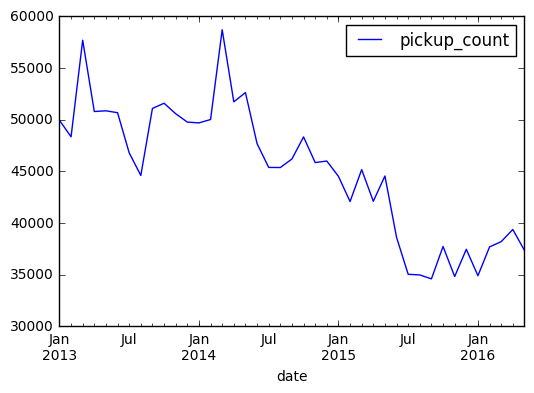

In [53]:
yp_man_loc[yp_man_loc.locationid == 4].groupby([pd.TimeGrouper('M')]).agg({'pickup_count':'sum'}).plot()

In [66]:
gp_man_loc = gp[gp.borough == 'Manhattan']

In [67]:
gp_man_loc = gp_man_loc.set_index('date')

In [68]:
gp_man_loc.head(2)

,locationid,trip_distance,pickup_count,LocationID,borough
date,,,,,
2014-01-01,24,3.044286,28,24,Manhattan
2014-01-01,41,3.050686,918,41,Manhattan


In [69]:
green_man = gp_man_loc[gp_man_loc.locationid == 4].groupby([pd.TimeGrouper('M')]).agg({'pickup_count':'sum'})

In [163]:
subway_man_loc = subway[subway.borough == 'Manhattan']
subway_man_loc = subway_man_loc.set_index('DATE')

In [165]:
subway_man_loc.head(2)

,LocationID,EXITS_DIFF,ENTRIES_DIFF,borough
DATE,,,,
2014-10-11,24,3917.0,9838.0,Manhattan
2014-10-11,41,14908.0,28535.0,Manhattan


In [89]:
uber_pre_man_loc = uber_pre[uber_pre.borough == 'Manhattan']
uber_post_man_loc = uber_post[uber_post.borough == 'Manhattan']

In [90]:
uber_pre_man_loc = uber_pre_man_loc.set_index('Date')
uber_post_man_loc = uber_post_man_loc.set_index('Date')

In [91]:
uber_pre_man_loc.head(2)

,LocationID,counts,borough
Date,,,
2014-04-01,4,81,Manhattan
2014-04-01,12,1,Manhattan


In [92]:
uber_post_man_loc.head(2)

,LocationID,counts,borough
Date,,,
2015-01-01,4,480,Manhattan
2015-01-01,12,5,Manhattan


In [112]:
yp_man_loc.locationid.unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 105, 107, 113, 114, 116, 120, 125, 127,
       128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161,
       162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261,
       262, 263, 104, 103])

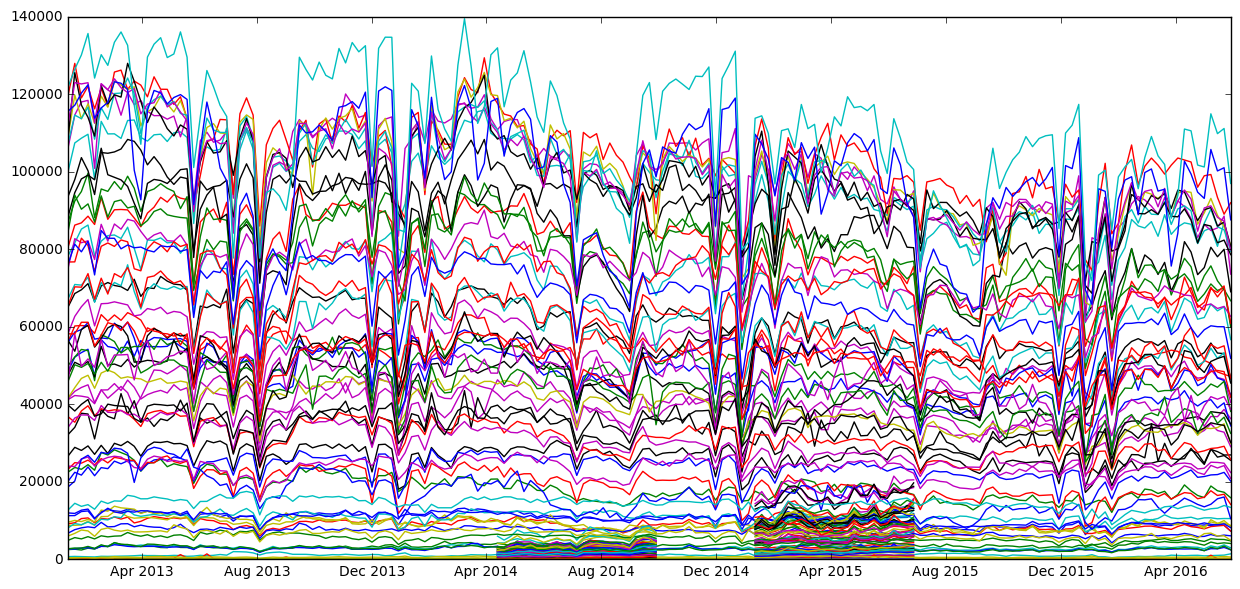

In [115]:
plt.figure(figsize=(15,7))
for loc in yp_man_loc.locationid.unique():
    
    uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == loc].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
    uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == loc].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
    yellow_man = yp_man_loc[yp_man_loc.locationid == loc].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]

    plt.plot(yellow_man.index, yellow_man.pickup_count)
    plt.plot(uber_pre_man.index, uber_pre_man.counts)
    plt.plot(uber_post_man.index, uber_post_man.counts)
# plt.plot(green_man.index, green_man.pickup_count)

# Yellow Pickup

In [206]:
top_locs = {}
for loc in yp_man_loc.locationid.unique():     
    
    top_locs[loc] = ((yp_man_loc[yp_man_loc.locationid == loc].pickup_count[0:100].sum() *1.0) / 
                      yp_man_loc[yp_man_loc.locationid == loc].pickup_count[-100:].sum())

print "Location with most change in pickups of yellow cabs:"    
sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[:20]

Location with most change in pickups of yellow cabs:


[(202, 2.2998204667863553),
 (166, 1.762587260466312),
 (105, 1.5317460317460319),
 (211, 1.5115437634200404),
 (125, 1.5063904066700406),
 (75, 1.4499601567709095),
 (158, 1.3942805992650522),
 (4, 1.3779453195031375),
 (144, 1.3697196371281861),
 (233, 1.359953322245131),
 (230, 1.3583671575264948),
 (45, 1.3443569021291943),
 (224, 1.3439876242957856),
 (107, 1.3415016870850316),
 (229, 1.3404935971367959),
 (249, 1.3385245611760128),
 (50, 1.3313455575134079),
 (113, 1.3308169294088412),
 (79, 1.3187129288684107),
 (143, 1.31503392365016)]

In [293]:
yellow_man

,pickup_count
date,
2013-01-13,34146
2013-01-20,36490
2013-01-27,37298
2013-02-03,37249
2013-02-10,35880
2013-02-17,39725
2013-02-24,37969
2013-03-03,37911
2013-03-10,38454


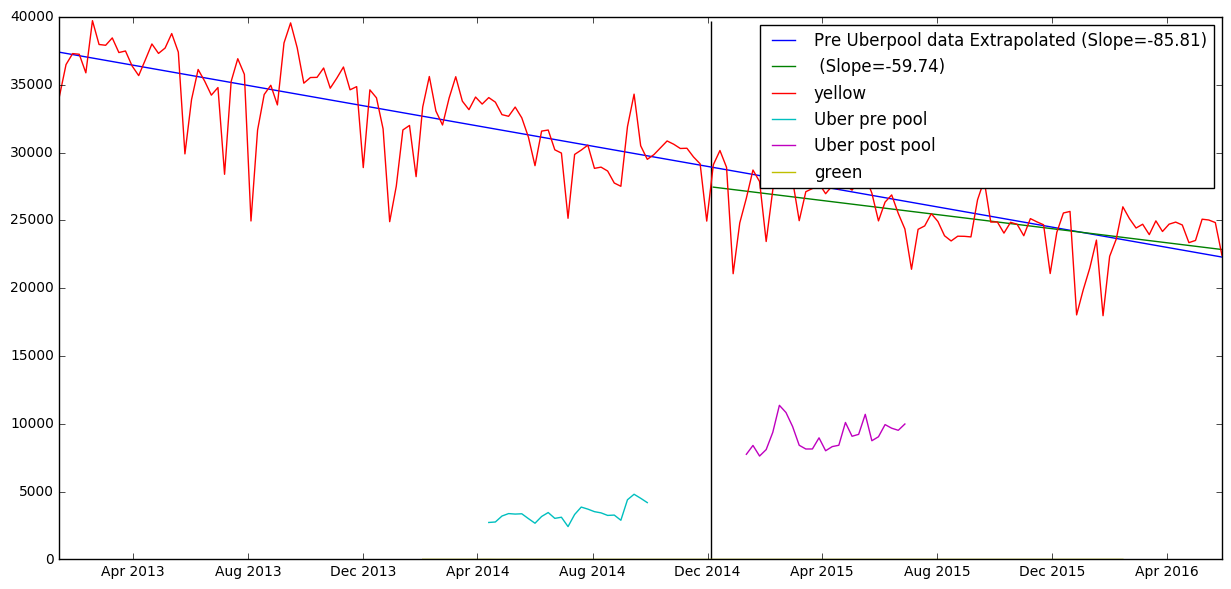

In [297]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 211].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 211].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 211].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 211].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]


a1,b1=polyfit(range(len(yellow_man[(yellow_man.index < '2014-12-04')])), 
              yellow_man[(yellow_man.index < '2014-12-04')].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yellow_man)))


a2,b2=polyfit(range(len(yellow_man[(yellow_man.index >= '2014-12-04') ])), 
              yellow_man[(yellow_man.index >= '2014-12-04')].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yellow_man[(yellow_man.index >= '2014-12-04')])))

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
plt.plot(yellow_man[(yellow_man.index >= '2014-12-04')].index, linreg2, label = " (Slope="+str(round(a2,2))+")")


plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

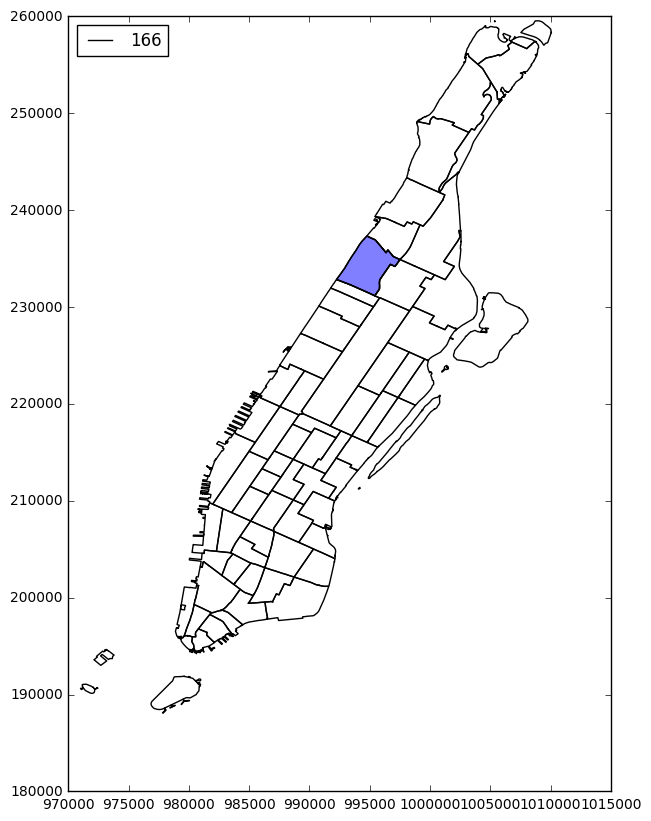

In [291]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[1:2]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
plt.legend(loc='best')

# Subway Entries

In [224]:
top_subway = {}
for loc in subway_man_loc.LocationID.unique():     
    
    top_subway[loc] = ((subway_man_loc[subway_man_loc.LocationID == loc].ENTRIES_DIFF[0:100].sum() *1.0) / 
                      subway_man_loc[subway_man_loc.LocationID == loc].ENTRIES_DIFF[-100:].sum())

print "Location with most change in pickups of subway entries:"    
sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:10]

Location with most change in pickups of subway entries:


[(161, 4.8117578502760177),
 (211, 1.9913700113195543),
 (230, 1.0563453089851935),
 (107, 1.0513032721834112),
 (229, 1.0323831532761645),
 (114, 1.0208740668105116),
 (68, 1.0192814064707332),
 (237, 1.0150426954703466),
 (239, 1.0130175790217553),
 (24, 0.99732985327071511)]

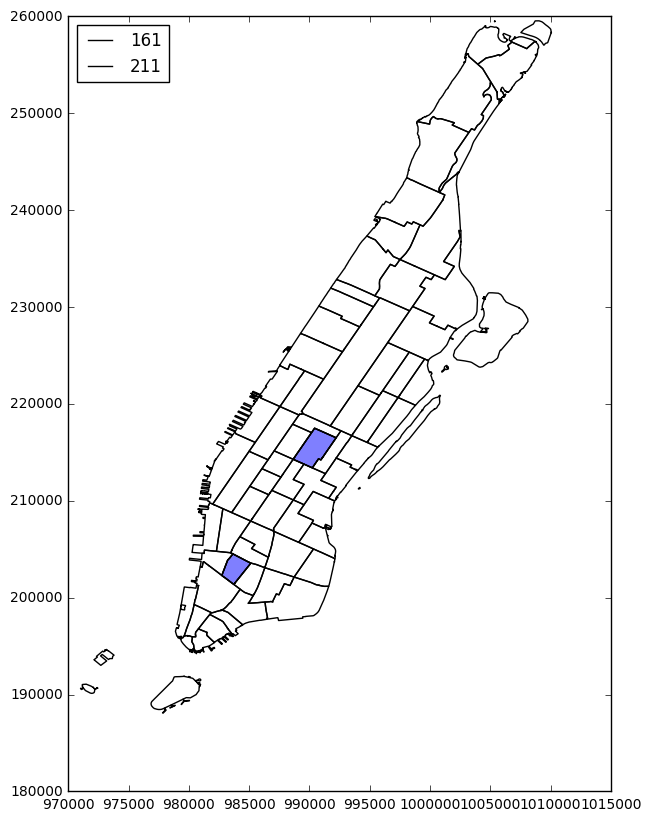

In [290]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')

for loc in sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:2]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])

plt.legend(loc='best')

# Uber pickups

In [232]:
top_uber = {}
for loc in uber_man_loc.LocationID.unique():     
    
    top_uber[loc] = ((uber_man_loc[uber_man_loc.LocationID == loc].counts[-100:].sum() *1.0) / 
                        uber_man_loc[uber_man_loc.LocationID == loc].counts[0:100].sum())

print "Location with most change in pickups of uber:"    
sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]

Location with most change in pickups of uber:


[(127, 17.130584192439862),
 (243, 12.584245076586432),
 (244, 10.571428571428571),
 (116, 10.286398467432949),
 (42, 9.8466889976810101),
 (152, 9.2942176870748305),
 (153, 8.3513513513513509),
 (74, 8.2359346642468232),
 (24, 7.5932291666666663),
 (41, 7.195876288659794)]

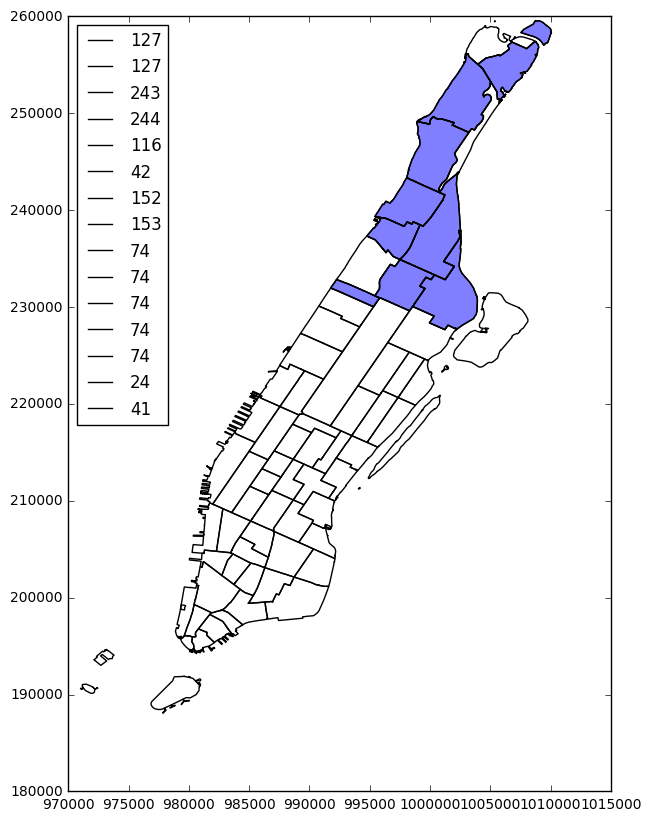

In [235]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
    
plt.legend(loc='best')

# Green Pickups

In [244]:
top_green = {}
for loc in gp_man_loc.locationid.unique():     
    
    top_green[loc] = ((gp_man_loc[gp_man_loc.LocationID == loc].pickup_count[200:400].sum() *1.0) / 
                        gp_man_loc[gp_man_loc.LocationID == loc].pickup_count[-100:].sum())

print "Location with most change in pickups of green cabs:"    
sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]

Location with most change in pickups of green cabs:


[(43, 68.277678571428567),
 (236, 33.425925925925924),
 (24, 19.345174262734584),
 (42, 9.5322166893013431),
 (202, 7.2422062350119907),
 (41, 7.072241816719262),
 (74, 6.3042638277175822),
 (263, 6.2948073701842544),
 (75, 6.0327728780176972),
 (116, 5.7986301369863016)]

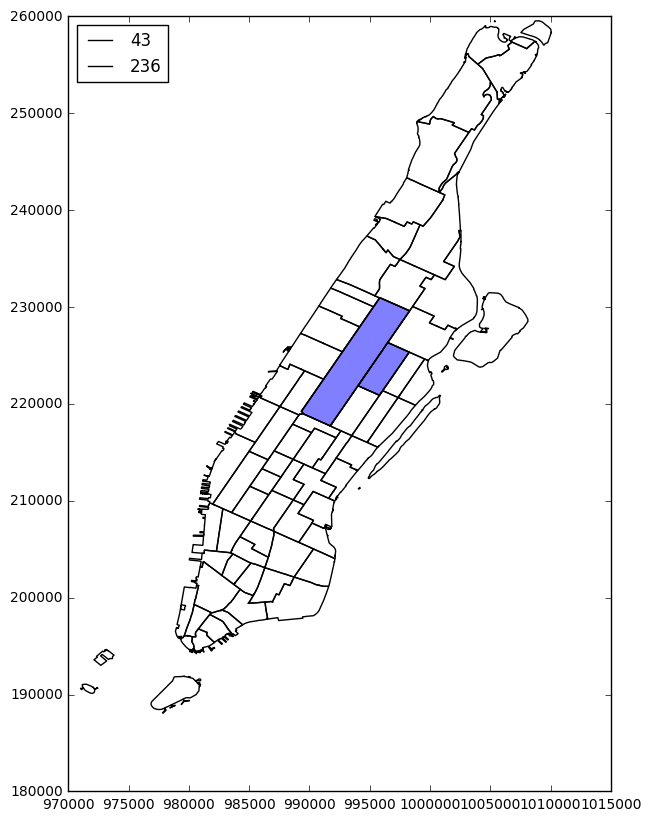

In [289]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
    
plt.legend(loc='best')

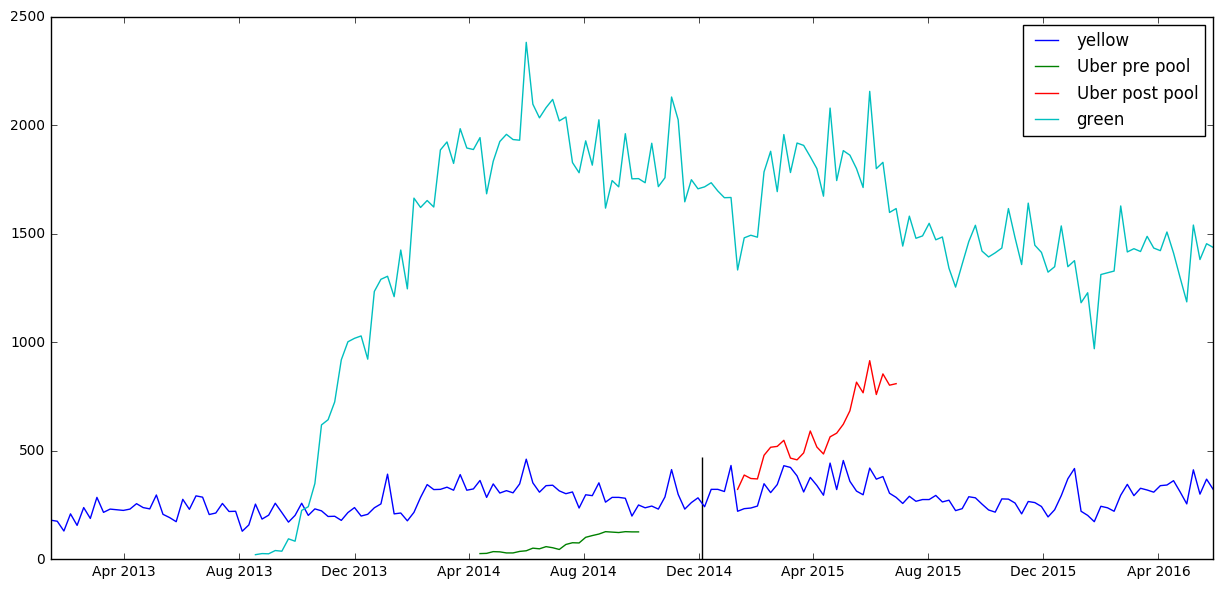

In [218]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 127].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 127].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 127].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 127].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

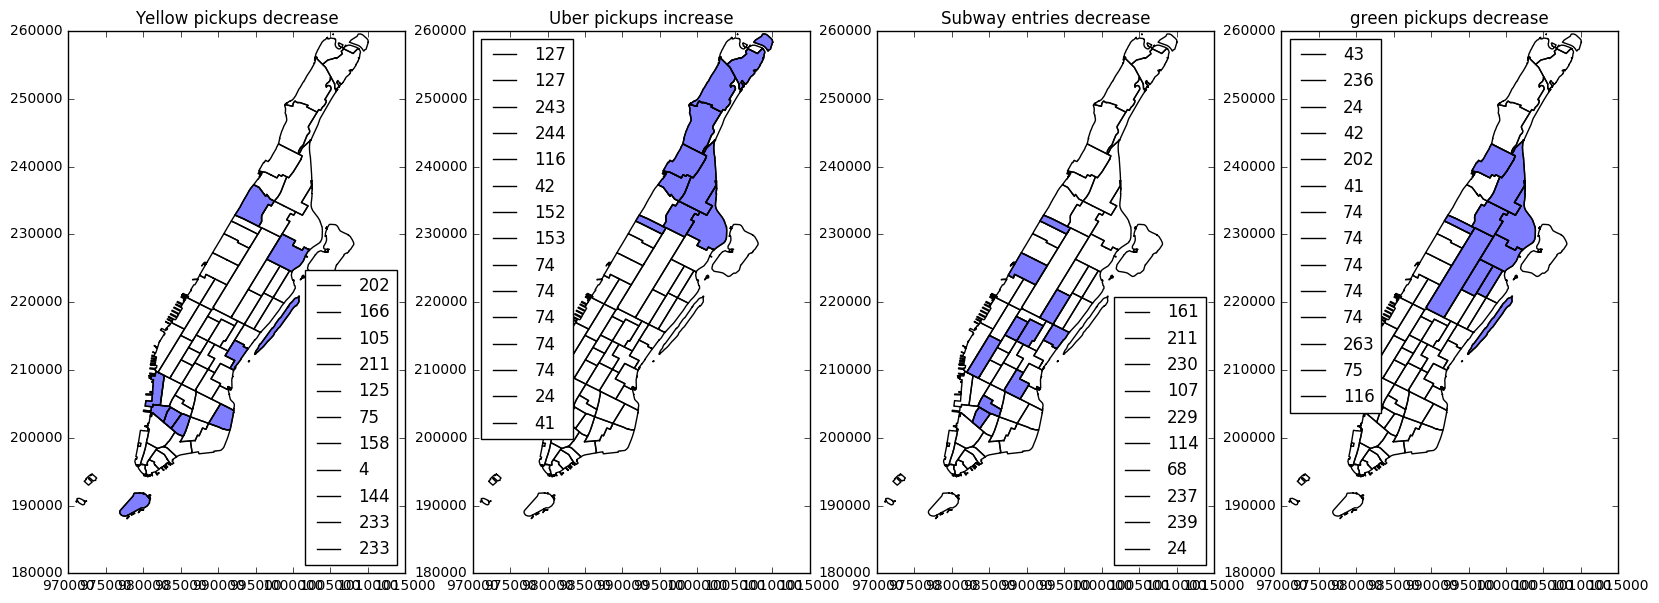

In [298]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,7))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax1, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax2, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax3, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax4, color = 'white')

for loc in sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax1, color = 'blue', label = loc[0])
ax1.legend(loc='best')
ax1.set_title('Yellow pickups decrease')

for loc in sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax2, color = 'blue', label = loc[0])
ax2.legend(loc='best')
ax2.set_title('Uber pickups increase')

for loc in sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax3, color = 'blue', label = loc[0])
ax3.legend(loc='best')
ax3.set_title('Subway entries decrease')

for loc in sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax4, color = 'blue', label = loc[0])
ax4.legend(loc='best')
ax4.set_title('green pickups decrease')

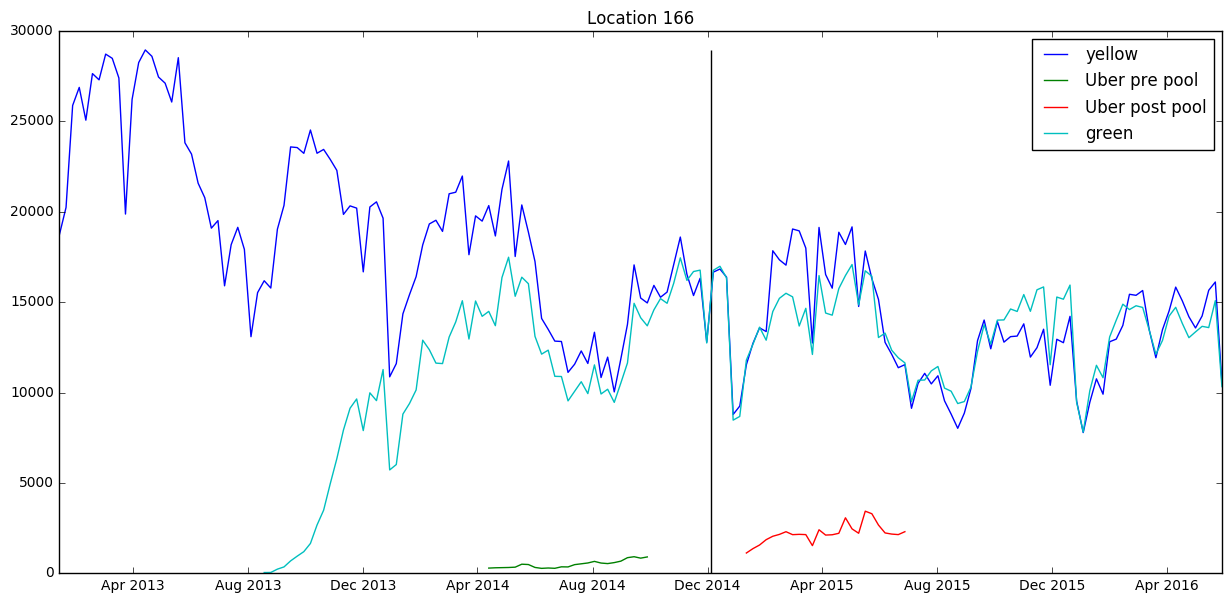

In [288]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 166].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 166].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 166].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 166].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
plt.title('Location 166')
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

In [34]:
yp_man = yp[yp.borough == 'Manhattan']
yp_man = yp_man.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

gp_man = gp[gp.borough == 'Manhattan']
gp_man = gp_man.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

In [15]:
uber_man = uber[uber.borough == 'Manhattan']
uber_man = uber_man.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})

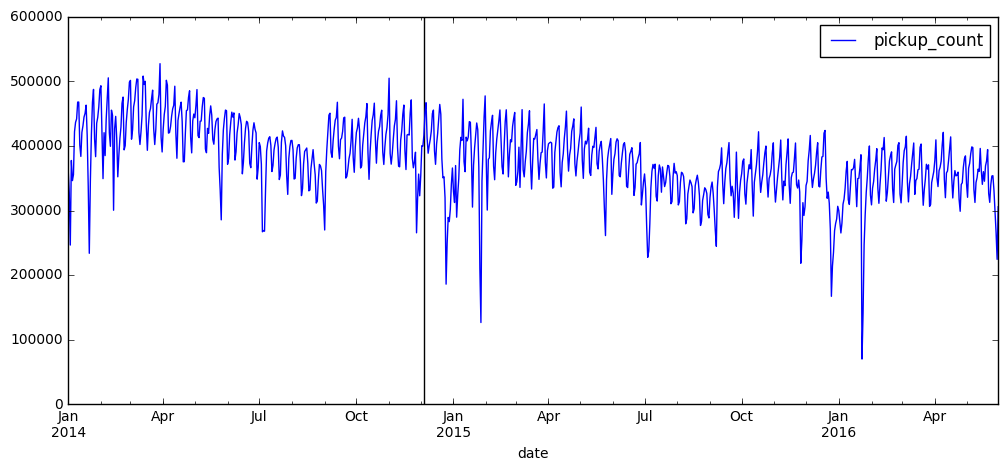

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
# gp_man.plot(ax=ax, label = 'Green Pickups')
# uber_man.rolling(window=10,center=False).mean().plot(ax=ax,label = 'Uber Pickups')


a1,b1=polyfit(range(len(yp_man[yp_man.index < '2014-12-04'])), 
              yp_man[yp_man.index < '2014-12-04'].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yp_man)))


a2,b2=polyfit(range(len(yp_man)), 
              yp_man.loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yp_man)))

# ax.plot(yp_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
# ax.plot(yp_man.index, linreg2, label = "Complete Data (Slope="+str(round(a2,2))+")")

yp_man.plot(ax=ax, label = 'Yellow Pickups')
plt.vlines(x='12-04-2014', ymin= 0, ymax= 600000)
plt.legend()




In [17]:
# Fourier extrapolation
# Function to use fourier transform for predictions
def fourierExtrapolation(x, n_predict):
    n = len(x)
    # number of harmonics in model
    n_harm = 80             
    t = np.arange(0, n)
    # find linear trend in x
    p = np.polyfit(t, x, 1)         
    # remove the trend
    x_notrend = x - p[0] * t        
    # x with no trend in frequency domain
    x_freqdom = np.fft.fft(x_notrend)  
    # calculating frequencies
    f = np.fft.fftfreq(n)              
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda z: np.absolute(f[z]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        # get amplitude
        ampli = np.absolute(x_freqdom[i]) / n   
        # get phase
        phase = np.angle(x_freqdom[i])          
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

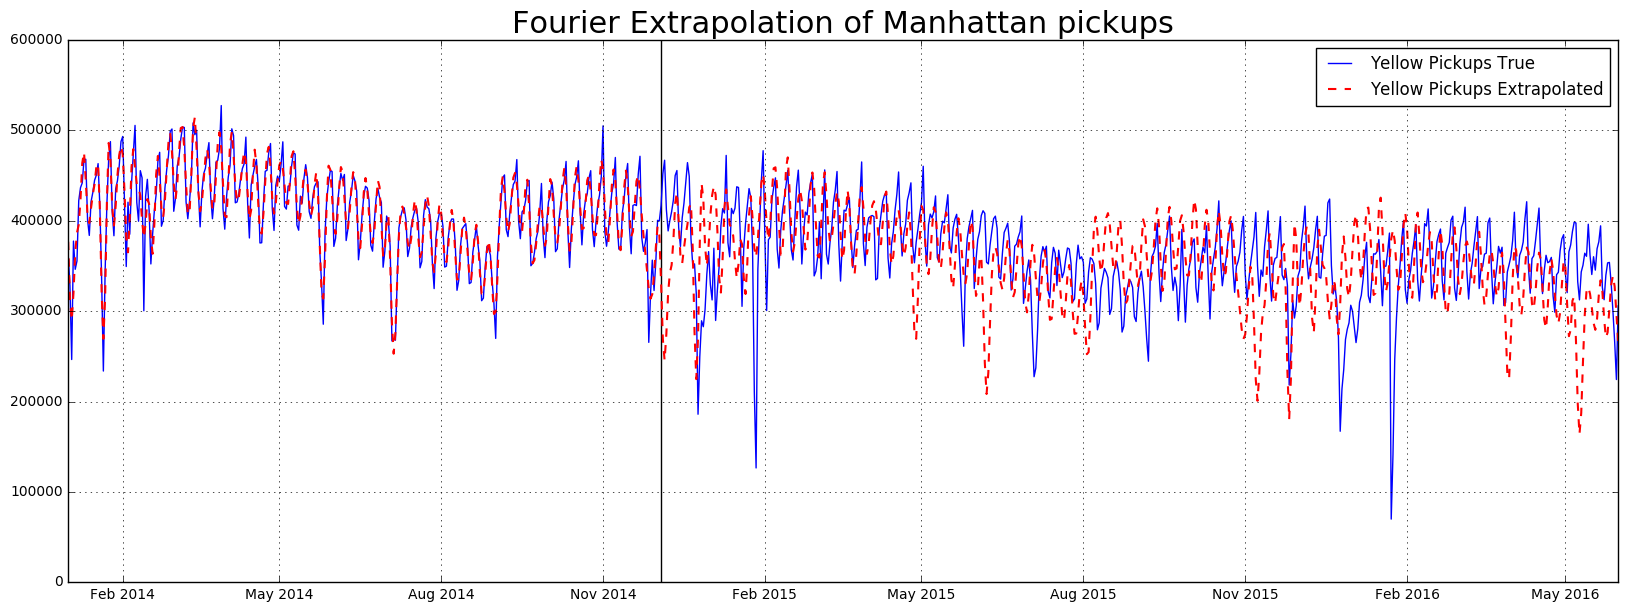

In [18]:
# Predicting through extrapolation
n_predict = 545
extrapolation = fourierExtrapolation(yp_man[yp_man.index < '2014-12-04']['pickup_count'], n_predict)
# difference = highlinemean[:167] - extrapolation[:167]
# a1, b1=polyfit(range(56, 167), difference[56:], 1)
# linreg1=polyval([a1, b1], range(56, 167))

# # Plotting Chelsea extrapolated by Fourier
fig, ax = plt.subplots(figsize=(20,7))
ax.grid(True)
zlot1 = ax.plot(yp_man , linewidth = 1, label = 'Yellow Pickups True', color = "blue")
plot4 = ax.plot(yp_man.index, extrapolation[:], linewidth = 1.5, label = 'Yellow Pickups Extrapolated',
                ls = "--", color = "red")
plt.vlines(x='12-04-2014', ymin=  00, ymax= 600000)
plt.title('Fourier Extrapolation of Manhattan pickups', size = 22)
plt.legend()

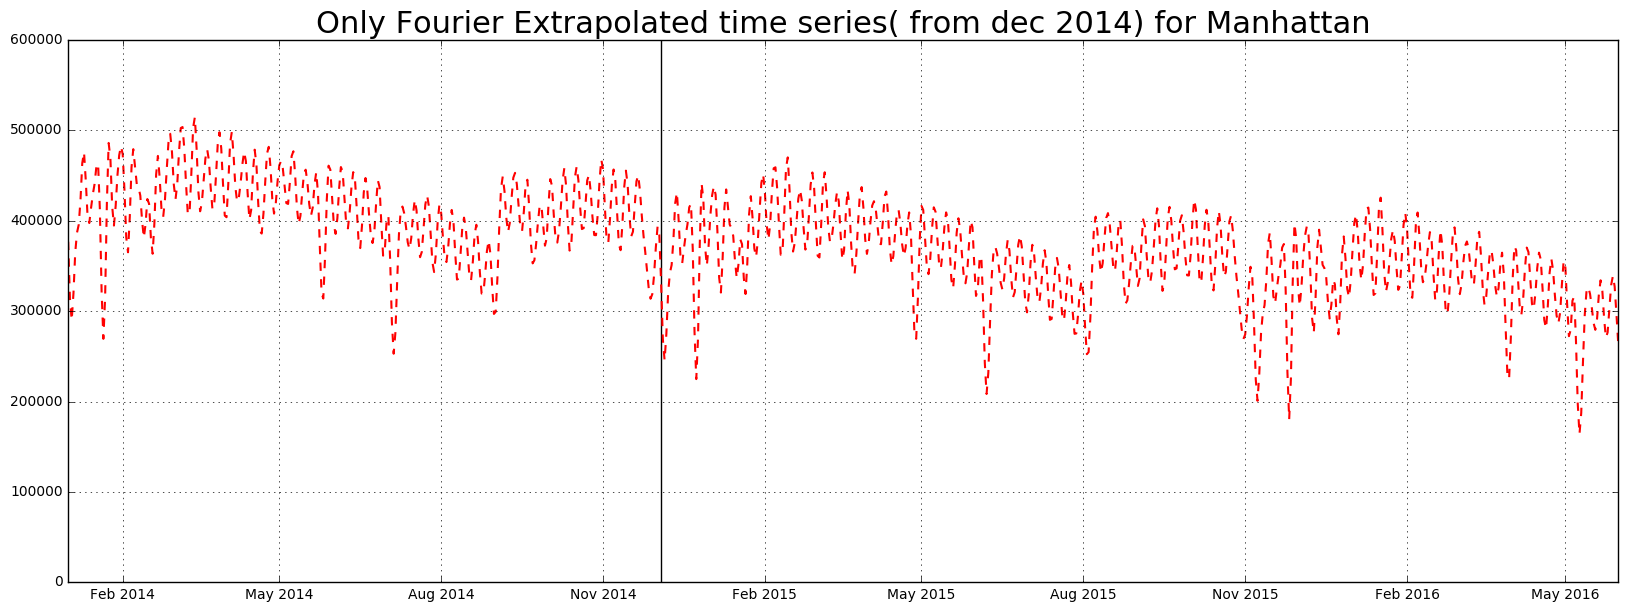

In [19]:
fig, ax = plt.subplots(figsize=(20,7))
ax.grid(True)
# zlot1 = ax.plot(yp_man , linewidth = 1, label = 'CHELSEA TRUE', color = "blue")
plot4 = ax.plot(yp_man.index, extrapolation[:], linewidth = 1.5, label = 'CHELSEA EXTRAPOLATION',
                ls = "--", color = "red")
plt.vlines(x='12-04-2014', ymin=  00, ymax= 600000)
plt.title('Only Fourier Extrapolated time series( from dec 2014) for Manhattan', size = 22)

# Brooklyn

In [20]:
yp_bk = yp[yp.borough == 'Brooklyn']
yp_bk = yp_bk.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})
# gp_man = gp[gp.borough == 'Manhattan']
# gp_man = gp_man.set_index('date').groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})

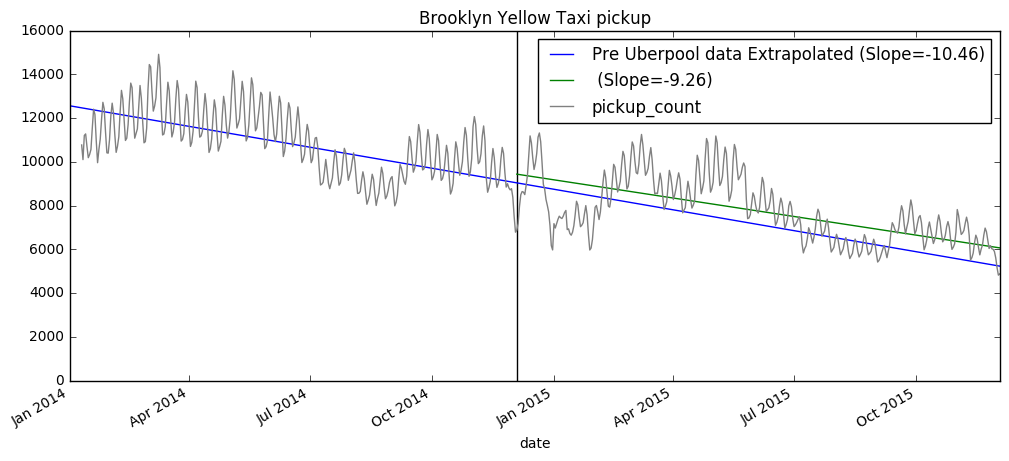

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
# gp_man.plot(ax=ax, label = 'Green Pickups')
# uber_man.rolling(window=10,center=False).mean().plot(ax=ax,label = 'Uber Pickups')


a1,b1=polyfit(range(len(yp_bk[(yp_bk.index < '2014-12-04')])), 
              yp_bk[(yp_bk.index < '2014-12-04')].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yp_bk[yp_bk.index < '2015-12-04'])))


a2,b2=polyfit(range(len(yp_bk[(yp_bk.index >= '2014-12-04') & (yp_bk.index < '2015-12-04')])), 
              yp_bk[(yp_bk.index >= '2014-12-04') & (yp_bk.index < '2015-12-04')].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yp_bk[(yp_bk.index >= '2014-12-04') & (yp_bk.index < '2015-12-04')])))

ax.plot(yp_bk[yp_bk.index < '2015-12-04'].index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
ax.plot(yp_bk[(yp_bk.index >= '2014-12-04') & (yp_bk.index < '2015-12-04')].index, linreg2, label = " (Slope="+str(round(a2,2))+")")

yp_bk[yp_bk.index < '2015-12-04'].rolling(window=10,center=False).mean().plot(ax=ax, label = 'Yellow Pickups', color = 'grey')
plt.vlines(x='12-04-2014', ymin= 0, ymax= 16000)
plt.title("Brooklyn Yellow Taxi pickup")
plt.legend()


